In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import numpy as np
import optax
from jax import numpy as jnp
from jax.numpy import fft
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.asyncd import utils
from otf.system import System_ModelKnown, utils as system_utils

from plot import plot

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values(x0: float, xf: float, n: int):
    """Get initial values for the true and nudged states.

    Parameters
    ----------
    x0, xf
        Endpoints of domain
    n
        Number of spatial grid points on [x0, xf]

    Returns
    -------
    u0
        Initial true state
    un0
        Initial nudged state
    """
    L = xf - x0

    # Initial true state
    u = lambda x: jnp.exp(-100 * (2 * np.pi / L * x - 1) ** 2)
    xls = jnp.linspace(x0, xf, n)
    u0 = u(xls)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    # return u0, un0
    return fft.rfft(u0), fft.rfft(un0)

In [ ]:
def compute_spatial_derivative(s: jndarray, m: int, k: jndarray) -> jndarray:
    """Compute mth spatial derivative of the state.

    Parameters
    ----------
    s
        System state (e.g., true or nudged) at a point in time in frequency
        domain
    m
        Number of spatial derivatives to take
    k
        Wave numbers

    Returns
    -------
    d^m s / d {x^m}
        Approximation of mth spatial derivative of s
    """
    return (2 * jnp.pi * 1j * k) ** m * s

In [ ]:
def true_ode(gs: jndarray, true: jndarray, k: jndarray) -> jndarray:
    return gs * compute_spatial_derivative(true, 1, k)


def assimilated_ode(
    cs: jndarray, assimilated: jndarray, k: jndarray
) -> jndarray:
    return cs * compute_spatial_derivative(assimilated, 1, k)


# System evolution parameters
g = -10
c = g
c *= -0.5
mu = 2
x0, xf = 0, 100
xn = 200
k = fft.rfftfreq(xn, (xf - x0) / xn)

gs = jnp.array([g], dtype=float)
cs = jnp.array([c], dtype=float)

true0, assimilated0 = get_initial_values(x0, xf, xn)

observed_slice = jnp.s_[:]
observed_mask = system_utils.mask_from_slice(observed_slice, true0.shape)
system = System_ModelKnown(
    mu,
    gs,
    cs,
    observed_mask,
    lambda cs, assimilated: assimilated_ode(cs, assimilated, k),
    lambda gs, true: true_ode(gs, true, k),
    complex_differentiation=True,
)

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)
solver = ti.FourStepAdamsBashforth(system, solver)

# Simulation parameters
dt = 0.005
T0, Tf = 0, 1200
t_relax = 1

gradient_computer = optim.gradient.AdjointGradient(
    system,
    dt,
    optim.gradient.adjoint.UpdateOption.complete,
    (ti.ForwardEuler, ti.TwoStepAdamsBashforth),
)
optimizer = optax.adam(1e-2 * 2)
optimizer = optim.OptaxWrapper(system, optimizer, gradient_computer)

true, tls_ = solver.solve_true(true0, T0, Tf, dt)
true_observed = true[:, observed_mask]

cs, u_errors, tls, nudged = utils.run_update(
    system,
    true_observed,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    assimilated0,
    optimizer,
    return_all=True,
)

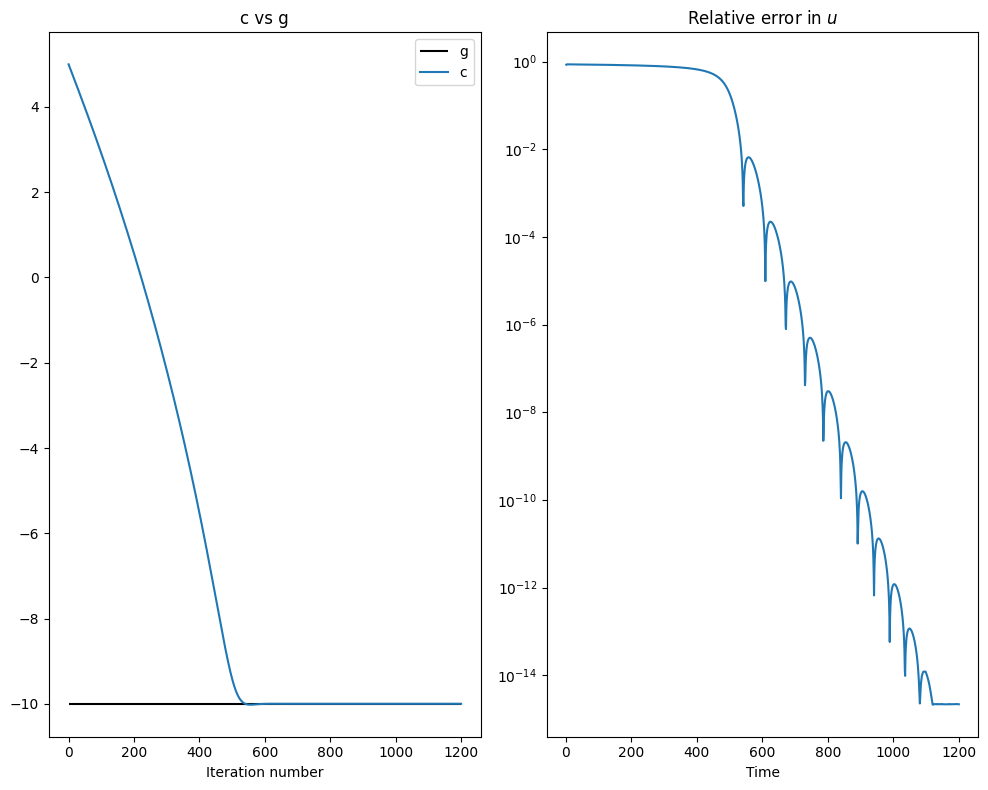

In [ ]:
fig, axs = plot(cs.real.T[0], u_errors, g, tls)
plt.show()